# Adding and using a custom model in PyCBC Inference

PyCBC offers the ability to make plug-in models for custom likelihood functions for Bayesian inference. While PyCBC was initially designed to do gravitational-wave data analysis, the ability to accept plug-in models means that PyCBC can be used to do Bayesian inference on virtually any problem. Creating a PyCBC plug-in model that wraps your likelihood function allows you to use PyCBC Inference to sample the parameter space of your problem. You can also combine a plug-in model with one of the built-in models (or other plug-in models) via the [HierarchicalModel](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.hierarchical.HierarchicalModel), thereby allowing for joint GW/anything-else Bayesian inference. Crucially, you can do this without needing to modify the PyCBC source code nor the source code of the target likelihood function. The plug-in simply allows the two pieces of code to talk to each other.

The basic requirements for creating a plugin model are:
 1. Create a model class that inherits from PyCBC's [BaseModel](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.base.BaseModel).
 1. Give the model a `name`, implement a `_loglikelihood` function, and (optionally) a `from_config` function.
 1. Add an `entry_points` argument with the appropriate values to the `setup` function in your `setup.py` file. 

The first two steps are needed so that your likelihood function can be called with the API that PyCBC Inference understands. The last step is needed so that PyCBC Inference can detect your model and use it.

In this tutorial we will demonstrate how to set up simple plug-in models, which we will register with PyCBC and use. We will also discuss how to create a setup file so that your models can be detected by `pycbc_inference` at run time. A working, installable version of the models found here can be found at  https://github.com/gwastro/example-models-plugin.

### Make sure PyCBC is installed

First we need to install PyCBC, if it has not been installed yet.

In [1]:
import sys
!{sys.executable} -m pip install pycbc --no-cache-dir
# we'll also need the ptemcee and epsie samplers, which are not installed by default
!{sys.executable} -m pip install "emcee==2.2.1" ptemcee epsie

You should consider upgrading via the '/Users/cdcapano/.virtualenvs/plugin-models/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/Users/cdcapano/.virtualenvs/plugin-models/bin/python -m pip install --upgrade pip' command.


The imports we'll need for this notebook:

In [2]:
import numpy
from matplotlib import pyplot
import logging

import pycbc
pycbc.init_logging(True)
from pycbc.inference import models
from pycbc.inference.models import BaseModel

2022-07-06 08:59:55,598 Setting verbosity to 0


## 1. Simple model example

Below we create a simple analytic model that uses a Poisson distribution as the likelihood function. As mentioned above, to do this we need to inherit from [BaseModel](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.base.BaseModel), give it a `name`, and implement a `_loglikelihood` function.

First, a little about [BaseModel](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.base.BaseModel): [BaseModel](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.base.BaseModel) is an [abstract base class](https://docs.python.org/3/library/abc.html#module-abc) that has certain "abstract" methods. This means that it cannot be initiated itself; instead, it is meant to be inherited by children classes. In order to be initialized, these children classes must implement their own versions of the abstract methods. Otherwise, an error will be raised. In this way, the abstract base class defines the necessary API that all classes inheriting from it must implement in order for them to be usable.

To illustrate this, let's try creating a class that just inherits from `BaseModel`, but does not implement anything:

In [3]:
class Foo(BaseModel):
    pass

try:
    foo = Foo()
except TypeError as e:
    print(e)
    pass

Can't instantiate abstract class Foo with abstract methods _loglikelihood


As we can see, we get a `TypeError` when we try to initialize the class. In the case of BaseModel, there is only one abstract method that needs to be initialized: the `_loglikelihood` function. In addition, we need to give the model a unique name, so that PyCBC knows how to identify it.

The `_loglikelihood` function is what calculates the log likelihood for your model. The function should take no arguments. This is because the parameter values that `_loglikelihood` will use are set by the `update` function. Within the `_loglikelihood` function the parameters to evaluate should be retrieved from the model's `current_params` attribute, which returns a dictionary of `parameter names -> values`.

To illustrate this, let's create a simple analytic model who's likelihood is given by the Poisson distribution:

In [4]:
from scipy import stats

class TestPoisson(BaseModel):
    """A model with a Poisson distribution for the likelihood."""
    name = 'test_poisson'
    
    def _loglikelihood(self):
        # get the current parameters;
        # they should have a mu and a counts
        params = self.current_params
        try:
            mu = params['mu']
            kk = int(params['k'])
        except KeyError:
            raise ValueError("must provide a mu and a k")
        return stats.poisson.logpmf(kk, mu)

Now let's register the model with PyCBC:

In [5]:
from pycbc.inference.models import register_model

In [6]:
register_model(TestPoisson)

2022-07-06 08:59:55,643 Custom model test_poisson will override a model of the same name. If you don't want this, change the model's name attribute.
2022-07-06 08:59:55,644 Custom model test_poisson will override a model of the same name. If you don't want this, change the model's name attribute.


We can now load the model using a config file. To test it out, let's create a config file that uses the model to estimate the distribution of foreground counts (`k`) given a fixed mean count (`mu`) of 3. Since `k` is an integer, we'll use the epsie sampler, which has a bounded discrete jump proposal.

In [7]:
config = """
[model]
name = test_poisson

[variable_params]
k =

[static_params]
mu = 3

[prior-k]
name = uniform
min-k = 0
max-k = 20

[sampler]
name = epsie
nchains = 10
ntemps = 1
niterations = 1000

[jump_proposal-k]
name = bounded_discrete
min-k = ${prior-k|min-k}
max-k = ${prior-k|max-k}

[sampler-burn_in]
burn-in-test = halfchain
"""

with open('poisson.ini', 'w') as fp:
    print(config, file=fp)

Now let's load the config file and use it to initialize the model. Note that we can initialize the model using pycbc.inference.models.read_from_config. This function looks at the `name` attribute in the `[model]` section to figure out which class it should call; it then calls that class's `from_config` method. This function will recognize our new class's `name` because we registered it above.

In [8]:
from pycbc.workflow import WorkflowConfigParser
from pycbc.inference import models

In [9]:
cp = WorkflowConfigParser(['poisson.ini'])

In [10]:
model = models.read_from_config(cp)

2022-07-06 08:59:55,670 Setting up priors for each parameter
2022-07-06 08:59:55,671 No sampling_params section read from config file


Let's test that the model works by evaluating a single point:

In [11]:
model.update(k=2)

model.loglikelihood

-1.4959226032237258

Now we'll setup the sampler and sample the parameter space, writing out to `possoin.hdf`:

In [12]:
import os
from pycbc.inference.sampler import load_from_config as load_sampler_from_config

sampler = load_sampler_from_config(cp, model, output_file='poisson.hdf')
sampler.run()
sampler.finalize()
os.rename(sampler.checkpoint_file, 'poisson.hdf')
os.remove(sampler.backup_file)

2022-07-06 08:59:55,696 Looking for checkpoint file
2022-07-06 08:59:55,697 Checkpoint not found or not valid
2022-07-06 08:59:55,697 Creating file poisson.hdf.checkpoint
2022-07-06 08:59:55,708 Running sampler for 0 to 1000 iterations
2022-07-06 08:59:58,136 Writing samples to poisson.hdf.checkpoint with thin interval 1
2022-07-06 08:59:58,149 Writing samples to poisson.hdf.bkup with thin interval 1
2022-07-06 08:59:58,161 Updating burn in
2022-07-06 08:59:58,162 Evaluating halfchain burn-in test
2022-07-06 08:59:58,164 Number of chains burned in: 10 of 10
2022-07-06 08:59:58,171 Computing autocorrelation time
2022-07-06 08:59:58,184 ACTs: min 3.0, mean (of finite) 4.1, max 5.0
2022-07-06 08:59:58,199 Validating checkpoint and backup files
2022-07-06 08:59:58,211 Clearing samples from memory


Now let's plot it with `plot_posterior`:

In [13]:
!pycbc_inference_plot_posterior \
    --input-file poisson.hdf \
    --output-file posterior-possion.png \
    --plot-marginal --verbose

2022-07-06 09:00:00,485 Reading input file poisson.hdf
2022-07-06 09:00:00,486 Loading samples
2022-07-06 09:00:00,490 Loaded 1259 samples
2022-07-06 09:00:00,491 Plotting
2022-07-06 09:00:00,799 Done


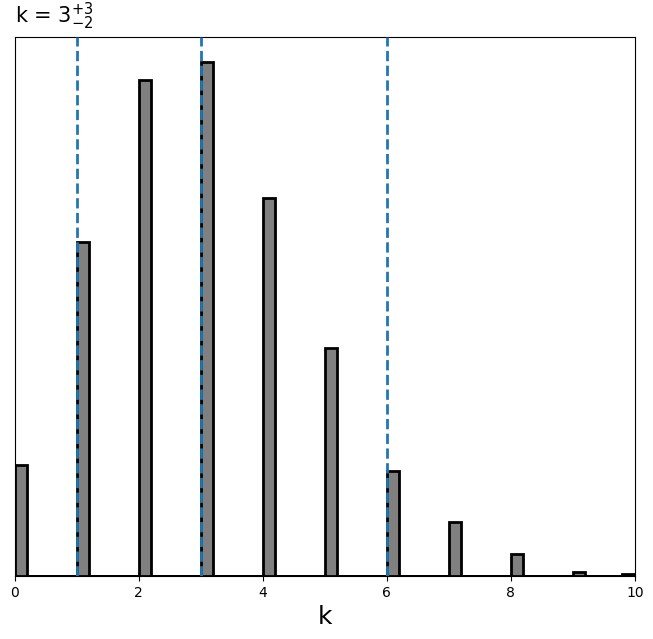

In [14]:
from IPython.display import Image
Image('posterior-possion.png', width=640)

## 2. Model with data example

In the above example the loglikelihood function was an analytic function. As a result we required no additional data input beyond the basic list of variable and static parameters, along with any transforms.

More frequently, however, we will need to load data from some input file, to compare against a noise and signal model. The data in this case may come from a gravitational-wave detector, a telescope, or any other experimental observation.

Loading data for a model occurs when the model is being initialized by `pycbc_inference`. When `pycbc_inference` starts, it loads the given configuration file(s) (supplied via the `--config-files` argument) and looks for the `[model]` section. The `[model]` section will have a `name` option that tells it which model class to load. The executable then calls that model's `.from_config` method to initialize the model.

All models in `pycbc_inference` have a `from_config` method. By default, models inherit this function from [BaseModel.from_config](http://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#pycbc.inference.models.base.BaseModel.from_config). The base model's `from_config` loads the variable and static parameters, the prior, and any sampling and/or waveform transforms that are specified in the config file. However, classes that inherit from BaseModel are free to override this, to obtain anything else that the model needs to be initialized.

This is where the flexibility of `pycbc_inference` exists. To the executable, the model is a black box. All the executable does is pass the model the config file and expect to get back a `BaseModel` instance that has a `loglikelihood` function it can call. You are therefore free to load whatever data you need (it need not be GW data) --- you just need to add the appropriate code to your model's `from_config` function to do so.

To illustrate this, we will create a fake data set that consists of some Poisson noise with a signal that is an exponentially decaying burst added to it. Such data may be from a GRB telescope, for example. We will then write a model similar to the TestPoisson one above that loads the data in its `from_config` method, and uses it in its likelihood function to estimate the signal's amplitude and damping time.

### The model:

In [15]:
class PoissonBurst(BaseModel):
    """A model in which the noise model is Poissonian and the signal model
    is an exponentially decaying burst.
    """
    name = 'poisson_burst'
    
    def __init__(self, times, counts, variable_params, **kwargs):
        super().__init__(variable_params, **kwargs)
        # store the data
        self.times = times
        self.counts = counts
        
    def _loglikelihood(self):
        params = self.current_params
        # the signal model
        amp = params['amp']
        tau = params['tau']
        t0 = params['t0']
        # generate the signal
        times = self.times
        signal = self.get_signal(times, amp, tau, t0)
        # subtract the signal from the observed data
        residual = self.counts - signal
        # make sure the residual is positive
        residual[residual < 0] = 0
        # the noise model parameters
        mu = params['mu']
        # the loglikelihood is the sum over the time series
        return stats.poisson.logpmf(residual, mu).sum()

    @staticmethod
    def get_signal(times, amp, tau, t0):
        """Generate the signal model.
        
        Having a function like this isn't required for the model;
        the signal could just be generated within the ``_loglikelihood``
        function. We break it out to a separate function here to
        make it easier to generate a simulated signal.
        """
        signal = numpy.zeros(len(times))
        mask = times >= t0
        signal[mask] = (amp*numpy.exp(-(times[mask]-t0)/tau)).astype(int)
        return signal
        
    @classmethod
    def from_config(cls, cp, **kwargs):
        """Loads the counts data in addition to the standard parameters.
        
        This requires a [data] section to exist in the config file that
        points to a text file containing the times and counts; example:
        
            [data]
            counts-data = /path/to/txt
        """
        # get the data
        datafn = cp.get('data', 'counts-data')
        data = numpy.loadtxt(datafn)
        times = data[:,0]
        counts = data[:,1]
        args = {'times': times, 'counts': counts}
        args.update(kwargs)
        return super().from_config(cp, **args)

In [16]:
# register the model
register_model(PoissonBurst)

2022-07-06 09:00:01,152 Custom model poisson_burst will override a model of the same name. If you don't want this, change the model's name attribute.


Now we'll generate a simulated signal and noise and save it.

In [17]:
# set a seed to make this reproducible
numpy.random.seed(10)

duration = 32
times = numpy.arange(duration)
# noise parameters
mu = 4
# generate some fake noise
noise = stats.poisson.rvs(mu, size=duration)

# simulated signal properties
t0 = duration/4
# we'll make the signal be a 10 sigma
# deviation from the noise
amp = 10 * mu**0.5 + mu
tau = duration/8
print('Signal parameters:')
print('amp: {}, tau: {}, t0: {}'.format(amp, tau, t0))
signal = PoissonBurst.get_signal(times, amp, tau, t0)

# the "observed" data
data = signal + noise
# save the data to a file
numpy.savetxt('simulated_data.txt', numpy.vstack((times, data)).T)

Signal parameters:
amp: 24.0, tau: 4.0, t0: 8.0


Here's what the simulated noise and signal look like:

/var/folders/w5/sfghyx2s5cb2f1dy9tn6hy7h0000gq/T/ipykernel_88087/2094703549.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


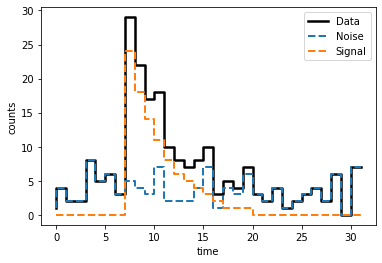

In [18]:
fig, ax = pyplot.subplots()
ax.step(times, data, c='black', lw=2.5, label='Data')
ax.step(times, noise, ls='--', lw=2, label='Noise')
ax.step(times, signal, ls='--', lw=2, label='Signal')
ax.set_xlabel('time')
ax.set_ylabel('counts')
ax.legend()
fig.show()

Now lets setup our configuration file to analyze it:

In [19]:
config = """
[model]
name = poisson_burst

[data]
counts-data = simulated_data.txt

[variable_params]
amp =
tau =

[static_params]
# we'll fix the noise parameters
mu = 4
t0 = 8

[prior-amp]
name = uniform
min-amp = 10
max-amp = 30

[prior-tau]
name = uniform
min-tau = 1
max-tau = 10

[sampler]
# this time we'll use the emcee sampler
name = emcee
nwalkers = 100
niterations = 4000

[sampler-burn_in]
burn-in-test = halfchain
"""

with open('poisson_burst.ini', 'w') as fp:
    print(config, file=fp)

Now we'll load the config file and do the inference:

In [20]:
cp = WorkflowConfigParser(['poisson_burst.ini'])
model = models.read_from_config(cp)

2022-07-06 09:00:01,321 Setting up priors for each parameter
2022-07-06 09:00:01,323 No sampling_params section read from config file


In [21]:
sampler = load_sampler_from_config(cp, model,
                                   output_file='poisson_burst.hdf')
sampler.run()
sampler.finalize()
os.rename(sampler.checkpoint_file, 'poisson_burst.hdf')
os.remove(sampler.backup_file)

2022-07-06 09:00:01,332 Looking for checkpoint file
2022-07-06 09:00:01,333 Checkpoint not found or not valid
2022-07-06 09:00:01,334 Creating file poisson_burst.hdf.checkpoint
2022-07-06 09:00:01,345 Running sampler for 0 to 4000 iterations
2022-07-06 09:00:58,567 Writing samples to poisson_burst.hdf.checkpoint with thin interval 1
2022-07-06 09:00:58,672 Writing samples to poisson_burst.hdf.bkup with thin interval 1
2022-07-06 09:00:58,769 Updating burn in
2022-07-06 09:00:58,770 Evaluating halfchain burn-in test
2022-07-06 09:00:58,771 Is burned in: True
2022-07-06 09:00:58,772 Burn-in iteration: 2000
2022-07-06 09:00:58,779 Computing autocorrelation time
2022-07-06 09:00:58,790 ACT: 54
2022-07-06 09:00:58,805 Validating checkpoint and backup files
2022-07-06 09:00:58,816 Clearing samples from memory


Let's plot the resulting posterior:

In [22]:
!pycbc_inference_plot_posterior \
    --input-file poisson_burst.hdf \
    --output-file posterior-possion_burst.png \
    --plot-marginal --plot-scatter --z-arg loglikelihood \
    --plot-contours --max-kde-samples 5000 \
    --expected-parameters amp:{amp} tau:{tau} \
    --verbose

2022-07-06 09:01:01,341 Reading input file poisson_burst.hdf
2022-07-06 09:01:01,342 Loading samples
2022-07-06 09:01:01,351 Loaded 3800 samples
2022-07-06 09:01:01,351 Getting samples for colorbar
2022-07-06 09:01:01,358 Plotting
2022-07-06 09:01:02,722 Done


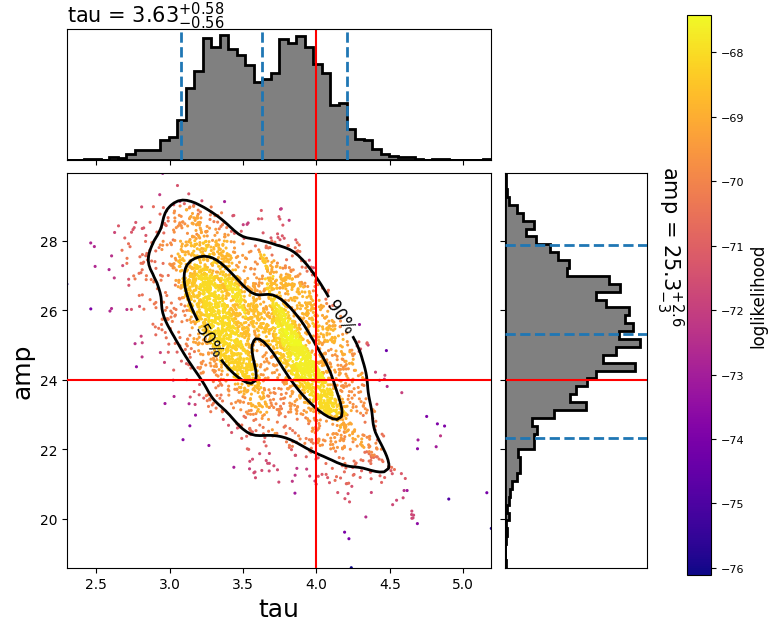

In [23]:
Image('posterior-possion_burst.png', width=640)

## 3. Using a plug-in model with `pycbc_inference`

In order to use our custom models with the `pycbc_inference` executable we need to create a plug-in package for them. As with all python packages, we will need to write a `setup.py` file for the package so that it can be installed into our environment. This file will look like any other `setup.py` with one important addition: we need to add an [entry_points](https://setuptools.pypa.io/en/latest/userguide/entry_point.html) argument to the `setup` function so that PyCBC can detect the package.

The `entry_points` argument takes a dictionary with format:
```
entry_points = {"pycbc.inference.models": ["(model name) = (module):(model)", ...]}
```

The dictionary key is a string that PyCBC will use look for to identify all plug-in models that have been installed. **The dictionary key must be set to `'pycbc.inference.models'` in order for pycbc to detect it.** The value is either a string or list of strings (if you have multiple models in the same repository that you want to add). For each model you want to add, the string should have the format above, where `(model name)` is the model's `name` attribute, `(module)` is the name of your plug-in module (this can be whatever you want, but should match whatever you set the `py_modules` argument to in the setup function) and `(model)` is the name of the model (i.e., the class name itself).

An example repository with the two Poisson models above is available at https://github.com/gwastro/example-models-plugin. You can see how the `entry_points` are specified in the [setup.py](https://github.com/gwastro/example-models-plugin/blob/master/setup.py) file there. Let's install the Poisson models into our environment using this repository. This will result in a `pycbc_poisson_models` package to exist in our environment (the name of the module is set by the `py_modules` argument). Due to the `entry_points` argument in the `setup.py` file, PyCBC will automatically detect this at runtime and allow us to use its models.

We can instruct pip to install directly from the repository:

In [24]:
!{sys.executable} -m pip install git+https://github.com/gwastro/example-models-plugin.git

  Cloning https://github.com/gwastro/example-models-plugin.git to /private/var/folders/w5/sfghyx2s5cb2f1dy9tn6hy7h0000gq/T/pip-req-build-f93jg2x2


  Created wheel for pycbc-poisson-models: filename=pycbc_poisson_models-0.0.dev0-py3-none-any.whl size=15386 sha256=147ca8c959fb60a17bd57a270a4f04f22a60ab8e4492c434bdc841c2ec39447f
  Stored in directory: /private/var/folders/w5/sfghyx2s5cb2f1dy9tn6hy7h0000gq/T/pip-ephem-wheel-cache-6h9wt7pm/wheels/70/76/62/806dbcd2b782fb35761a42a98d62ca9e89f39958802e3d0e8c
Successfully built pycbc-poisson-models
You should consider upgrading via the '/Users/cdcapano/.virtualenvs/plugin-models/bin/python -m pip install --upgrade pip' command.


With the models installed in our environment we can now use `pycbc_inference` with them. Let's repeat the analytical Poisson analysis above, using the `poisson.ini` file we created: 

In [25]:
!pycbc_inference --verbose \
    --config-file poisson.ini \
    --output-file poisson.hdf \
    --force \
    --seed 100

2022-07-06 09:01:08,281 Using seed 100
2022-07-06 09:01:08,281 Running with CPU support: 1 threads
2022-07-06 09:01:08,281 Reading configuration file
2022-07-06 09:01:08,282 Setting up model
2022-07-06 09:01:08,283 Custom model test_poisson will override a model of the same name. If you don't want this, change the model's name attribute.
2022-07-06 09:01:08,283 Setting up priors for each parameter
2022-07-06 09:01:08,284 No sampling_params section read from config file
2022-07-06 09:01:08,284 Setting up sampler
2022-07-06 09:01:08,286 Looking for checkpoint file
2022-07-06 09:01:08,286 Checkpoint not found or not valid
2022-07-06 09:01:08,286 Creating file poisson.hdf.checkpoint
2022-07-06 09:01:08,299 Running sampler for 0 to 1000 iterations
2022-07-06 09:01:10,949 Writing samples to poisson.hdf.checkpoint with thin interval 1
2022-07-06 09:01:10,960 Writing samples to poisson.hdf.bkup with thin interval 1
2022-07-06 09:01:10,968 Updating burn in
2022-07-06 09:01:10,969 Evaluating hal

Now plot it:

In [26]:
!pycbc_inference_plot_posterior \
    --input-file poisson.hdf \
    --output-file posterior-possion.png \
    --plot-marginal --verbose

2022-07-06 09:01:13,681 Reading input file poisson.hdf
2022-07-06 09:01:13,681 Loading samples
2022-07-06 09:01:13,686 Loaded 1025 samples
2022-07-06 09:01:13,686 Plotting
2022-07-06 09:01:13,993 Done


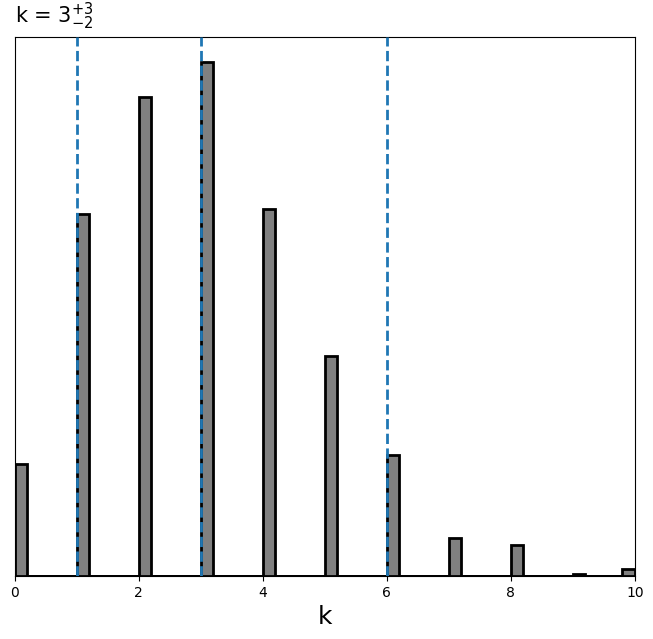

In [27]:
Image('posterior-possion.png', width=640)

### Challenge problem:

 * Write your own custom model that uses the [gamma distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) for the log likelihood. Call it `TestGamma`. This model should be similar to `TestPoisson`, above, but with the `poisson.logpmf` function replaced with `gamma.logpdf` in the `_loglikelihood` function.
 * Create a config file to sample it. As we did with the Poisson distribution, fix the shape parameter and sample the x parameter. If you use the epsie sampler (as we did above) note that you'll want to change the jump proposal from `bounded_discrete` to `bounded_normal`, since the gamma distribution is continuous.
 * Sample the distribution and plot it.
 * Put your model into a `.py` file in its own directory and create a `setup.py` file for it. Install it into your environment and use the `pycbc_inference` executable to sample it.